In [0]:
%tensorflow_version 2.x

In [0]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import *
from tensorflow.keras.utils import *
from tensorflow.keras.layers import *
from tensorflow.keras.datasets import imdb

### Hyperparameters
#### Epoch: 10
#### Initial Learning Rate: 1e-3
#### Batch  Size: 512
#### Kernel Initializer: Orthogonal(default)


In [0]:
max_features = 10000
maxlen = 400
epoch = 10
learning_rate = 1e-3
batch = 512
initializer = initializers.Orthogonal(seed=114)
use_cudnn = True
use_regulizar = False

In [0]:
if(use_cudnn):
  recurrent_dropout = 0
else:
  recurrent_dropout = 0.5
if(use_regulizar):
  regularizer = regularizers.l2(0.05)
else:
  regularizer = None
  

In [0]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)
y_train = np.array(y_train)
y_test = np.array(y_test)

### 定義 residual_block :
#### residual = x
#### x = basic_layer(basic_layer(x))
#### residual_block = x + residual

In [0]:
def cnn_layer(units, dropoutrate = 0):
    layer = models.Sequential()
    layer.add(LayerNormalization())
    layer.add(Conv1D(filters=units, kernel_size=1, strides=1, padding='same'))
    if(dropoutrate>0):
        layer.add(SpatialDropout1D(dropoutrate))
    layer.add(layers.Activation('elu'))
    return layer

In [0]:
def rnn_layer(units, recurrent_dropout,dropout=0.5, dropoutrate = 0, rnn = 'GRU'):
    layer = models.Sequential()
    layer.add(LayerNormalization())
    if(rnn == 'GRU'):
      layer.add(Bidirectional(GRU(units, kernel_initializer=initializer, dropout=dropout, kernel_regularizer=regularizer, recurrent_dropout=recurrent_dropout, return_sequences=True)))
    elif(rnn == 'LSTM'):
      layer.add(Bidirectional(LSTM(units, kernel_initializer=initializer, dropout=dropout, kernel_regularizer=regularizer, recurrent_dropout=recurrent_dropout, return_sequences=True)))
    else:
      layer.add(Bidirectional(RNN(units, kernel_initializer=initializer, dropout=dropout, kernel_regularizer=regularizer, recurrent_dropout=recurrent_dropout, return_sequences=True)))
    if(dropoutrate>0):
        layer.add(SpatialDropout1D(dropoutrate))
    layer.add(layers.Activation('elu'))
    return layer

In [0]:
model = Sequential()
model.add(Embedding(10000, 128, input_length=maxlen))
model.add(SpatialDropout1D(0.25))
model.add(cnn_layer(128, 0.25))
model.add(cnn_layer(256, 0.25))
model.add(rnn_layer(256, recurrent_dropout, 0.5, 0.25))
model.add(rnn_layer(128, recurrent_dropout, 0.5, 0.25))
model.add(rnn_layer(64, recurrent_dropout, 0.5, 0.25))
model.add(rnn_layer(32, recurrent_dropout, 0.5, 0.25))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 400, 128)          1280000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 400, 128)          0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 400, 128)          16768     
_________________________________________________________________
sequential_2 (Sequential)    (None, 400, 256)          33280     
_________________________________________________________________
sequential_3 (Sequential)    (None, 400, 512)          790016    
_________________________________________________________________
sequential_4 (Sequential)    (None, 400, 256)          494080    
_________________________________________________________________
sequential_5 (Sequential)    (None, 400, 128)          1

#### Optimizer : Adam
#### Train : Validation : Test = 4 : 1 : 5



In [0]:
adam = optimizers.Adam(lr = learning_rate, clipvalue=0.5)
model.compile(optimizer= adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=2)
history = model.fit(x_train,
                    y_train, 
                    batch_size=batch, 
                    epochs=epoch,
                    validation_split = (1/5),
                    verbose=1, 
                    # callbacks=[early_stop]
                    )  

Epoch 1/10
40/40 [==============================] - 55s 1s/step - loss: 0.7295 - accuracy: 0.4989 - val_loss: 0.6879 - val_accuracy: 0.5415
Epoch 2/10
40/40 [==============================] - 53s 1s/step - loss: 0.6896 - accuracy: 0.5387 - val_loss: 0.6057 - val_accuracy: 0.6406
Epoch 3/10
40/40 [==============================] - 53s 1s/step - loss: 0.4832 - accuracy: 0.7783 - val_loss: 0.3233 - val_accuracy: 0.8638
Epoch 4/10
40/40 [==============================] - 53s 1s/step - loss: 0.2780 - accuracy: 0.8913 - val_loss: 0.3124 - val_accuracy: 0.8709
Epoch 5/10
40/40 [==============================] - 53s 1s/step - loss: 0.2019 - accuracy: 0.9252 - val_loss: 0.3512 - val_accuracy: 0.8551
Epoch 6/10
40/40 [==============================] - 53s 1s/step - loss: 0.1833 - accuracy: 0.9332 - val_loss: 0.2727 - val_accuracy: 0.8854
Epoch 7/10
40/40 [==============================] - 53s 1s/step - loss: 0.1243 - accuracy: 0.9579 - val_loss: 0.3329 - val_accuracy: 0.8731
Epoch 8/10
40/40 [==

In [0]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

782/782 - 53s - loss: 0.3848 - accuracy: 0.8680


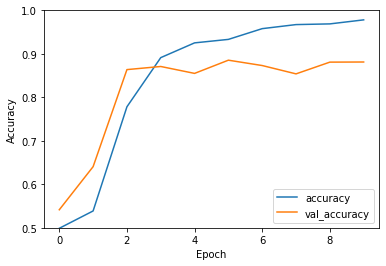

In [0]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
# plt.savefig("ann_acc.png", dpi=500)

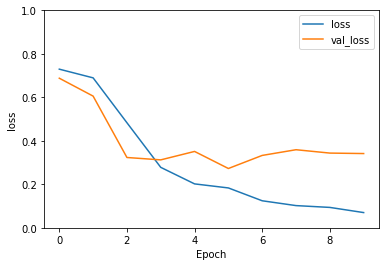

In [0]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0, 1])
plt.legend(loc='upper right')
# plt.savefig("ann_loss.png", dpi=500)

##Result : 
### Train accuracy: 93.63%
### Valid accuracy: 93.40%
### Test  accuracy: 92.51%
#### Early_stopping讓模型在第31個epoch就停止訓練
